# Gridworld

*Andrea Mazzolini*, andrea.mazzolini.90@gmail.com.


Here we want to find the optimal strategy of a 2d grid-world problem having full information.
**Value iteration** algorithm will be used.

## Gridworld as a Markov Decision Process

### States
The state space corresponds to the physical space of the gridworld. Therefore each state is identified by the two coordinates, and the whole space is composed of $d^2$ states:

$$
\mathcal{S} = \{ 0, 1, \ldots, d-1 \} \times \{ 0, 1, \ldots, d-1 \}
$$

### Actions
The actions of the agent are five: he can move to nearest neighbours or stay in the cell without moving:

$$
\mathcal{A} = \{ \text{up}, \text{left}, \text{down}, \text{right}, \text{stay} \} = \{ (0,1), (-1,0), (0,-1), (1,0), (0,0)\}
$$

which can be expressed also translation vectors.
Actually, these actions are not always possible in each state: the agent cannot cross boundaries. This makes actions state dependent, for example if the agent is located on the left boundary: $\mathcal{A}(0,y) = \{ \text{up}, \text{down}, \text{right}, \text{stay} \}$, or in a corner: $\mathcal{A}(d-1,d-1) = \{ \text{left}, \text{down}, \text{stay} \}$.

### Transition probabilities

The transition probabilities between states are deterministic: the next state is just the old state plus the translation action chosen by the agent:

$$
p(s_{t+1} | a_t, s_t) = \delta (s_{t+1} = a_t + s_t)
$$

### Rewards

The rewards depends only on the arrival states, $r(s_{t+1})$, and are zero for all the states with the exception of some special ones chosen to contain some resource.

## Value iteration algorithm

* Initialise the values of all the states $V^{(0)}(s)$.

* For $t$ in $[1,2,\ldots]$ until a *convergence condition* is satisfied do:
> * for each state $s$:
> > * Compute the new value estimate using the Bellman equation: $ V^{(t)}(s) = \max_{a} \sum_{s'} p(s'|s,a)\big[ r(s',a, s) + \gamma\,V^{(t-1)}(s') \big] $

## Implementation

### Environment class: the gridworld

The Gridworld class contains all the information about the environment:
- The info about the state space (cells and obstacles).
- The set of possible actions from each state.
- The reward table: which reward the agent take in each cell (0 if none).

The methods are:
- `display()`: Plot the gridworld.
- `display_best_path(values, gamma, start_cell)`: Plot the best path from the `start_cell`.

In [1]:
import numpy as np
from copy import copy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm


class Gridworld:

    def __init__(self, grid_size, rewards, obstacles=[]):
        """
        Training environment for reinforcement learning: gridworld.
        Args:
        - grid_size, (int, int): defining the size of the 2d lattice
        - init_cell, (int, int): coordinates from 0 to size-1 from which the agent starts to play
        - rewards, list((int, int), float): list of the coordinates§ and values of the rewards
        - obstacles, lits((int, int)): list of the coordinates of the obstacles
        """

        # Define state space
        self.state = None  # current state of the game
        self.state_dim = grid_size
        #self.init_state = init_cell
        self.obstacles = obstacles
        # Cells that are not obstacles
        self.states = [(i,j) for i in range(self.state_dim[0]) for j in range(self.state_dim[1]) if (i,j) not in self.obstacles] 

        # Define action space
        self.action_dim = (5,)  # up, right, down, left, stay
        self.action_dict = {"up": 0, "right": 1, "down": 2, "left": 3, "stay": 4}
        self.action_coords = [(0, 1), (1, 0), (0, -1), (-1, 0), (0, 0)]  # translations
        self.actions_allowed = self._build_allowed_actions(obstacles)

        # Define rewards table
        self.R = self._build_rewards(rewards)


    def _build_allowed_actions(self, obstacles):
        actions_allowed = dict()
        Nx, Ny = self.state_dim
        for x in range(Nx):
            for y in range(Ny):
                # Actions not allowed at the boundaries
                actions_allowed[(x,y)] = [self.action_dict["stay"]] # The stay action is always allowed
                if (y > 0):  
                    actions_allowed[(x,y)].append(self.action_dict["down"])
                if (y < Ny - 1):  
                    actions_allowed[(x,y)].append(self.action_dict["up"])
                if (x > 0):  
                    actions_allowed[(x,y)].append(self.action_dict["left"])
                if (x < Nx - 1):  
                    actions_allowed[(x,y)].append(self.action_dict["right"])
                actions_allowed[(x,y)] = np.array(actions_allowed[(x,y)], dtype=int)

                # Actions not allowed because of obstacles
                for o in obstacles:
                    if (x+1,y) == o:
                        actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["right"]]
                    if (x-1,y) == o:
                        actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["left"]]
                    if (x,y+1) == o:
                        actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["up"]]
                    if (x,y-1) == o:
                        actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["down"]]
        return actions_allowed


    def _build_rewards(self, rewards):
        R = np.zeros(self.state_dim, dtype=float)
        for rew in rewards:
            R[rew[0]] = rew[1]
        return R

    def display(self, values=np.array([]), cmap=sns.dark_palette("red", as_cmap=True), figsize=(7,6)):
        fig = plt.figure(figsize=figsize)
        obstacle_mask = np.zeros(self.state_dim, dtype=bool)
        for obs in self.obstacles:
            obstacle_mask[obs[0], obs[1]] = True

        if len(values)==0:
            ax = sns.heatmap(obstacle_mask.T, cmap=cm.get_cmap("Greys"), cbar=False, 
                       linewidths=0.1, linecolor='#222222')
        else:
            ax = sns.heatmap(values.T, mask=obstacle_mask.T, cmap=cmap, 
                       linewidths=0.1, linecolor='#222222', vmin=np.min(values[values != 0]))
            ax.collections[0].colorbar.set_label("Value", fontsize=14)

        ax.invert_yaxis()
        ax.set_xlabel('x', fontsize=14)
        ax.set_ylabel('y', fontsize=14)
        #ax.scatter([start_cell[0]+0.5],[start_cell[1]+0.5], s=100, c='grey', label='Start')
        
        for rew in rewards:
            ax.scatter([rew[0][0]+0.5],[rew[0][1]+0.5], s=200*rew[1], c='red', label='Reward:{}'.format(rew[1]), marker='*')
        plt.tight_layout()

        return fig, ax


    def display_best_path(self, values, gamma, start_coord, lcolor='black', cmap=sns.dark_palette("red", as_cmap=True), figsize=(7,6)):
        fig, ax = self.display(values, cmap, figsize)
        obstacle_mask = np.zeros(self.state_dim, dtype=bool)

        s, count, best_action = start_coord, 0, 0
        while best_action != 4 or count < self.state_dim[0]*self.state_dim[1]:
            count += 1
            qualities = np.zeros(5)
            for a in self.actions_allowed[s]:
                new_s = (self.action_coords[a][0] + s[0], self.action_coords[a][1] + s[1])
                qualities[a] = self.R[new_s] + gamma*values[new_s]
            best_action = np.argmax(qualities)
            new_s = s[0] + self.action_coords[best_action][0], s[1] + self.action_coords[best_action][1]
            ax.plot([s[0]+0.5, new_s[0]+0.5], [s[1]+0.5, new_s[1]+0.5], c='black', lw=3)
            s = new_s

        plt.tight_layout()

        return fig, ax

<Figure size 864x432 with 0 Axes>

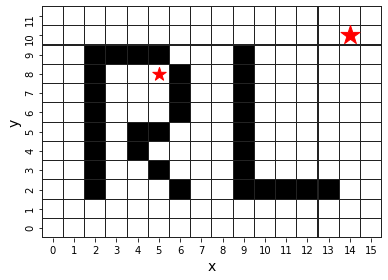

In [2]:
world_size = (16,12) # dimension of the gridworld

#start_cell = (1,1)

obstacles = [(2,2), (2,3), (2,4), (2,5), (2,6), (2,7), (2,8), (2,9), 
             (3,9), (4,9), (5,9), (6,8), (6,7), (6,6), (5,5), (4,5),
             (4,4), (5,3), (6,2),
             (9,2), (9,3), (9,4), (9,5), (9,6), (9,7), (9,8), (9,9), 
             (10,2), (11,2), (12,2), (13,2)]

rewards = [((5, 8), 1), ((14, 10), 2)]

gridworld = Gridworld(world_size, rewards, obstacles) # Building the world
plt.figure(figsize=(12, 6))
fig, ax = gridworld.display(figsize=(5.5,4)) # And showing it
#ax.legend(fontsize=14)

In [3]:
def val_iter_gridworld(gridworld, gamma, delta_conv=0.001, max_time=1000):
    """
    Value iteration algorithm applied to Gridworld. It returns the computed value 
    function as a 2d array.
    """
    values = np.zeros(gridworld.state_dim)
    for t in range(max_time):
        old_values = copy(values)
        delta_v = 0
        for s in gridworld.states:
            qualities = np.array([])
            for a in gridworld.actions_allowed[s]:
                new_s = (gridworld.action_coords[a][0] + s[0], gridworld.action_coords[a][1] + s[1])
                qualities = np.append(qualities, gridworld.R[new_s] + gamma * old_values[new_s])
            values[s] = qualities.max()
            delta_v = max(delta_v, abs(values[s] - old_values[s]))
        
        if delta_v < delta_conv:
            break
            
    return values

In [8]:
gamma = 0.75

values = val_iter_gridworld(gridworld, gamma)

(<Figure size 396x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x262b10030b8>)

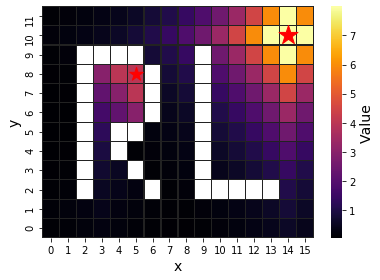

In [9]:
gridworld.display(values, cmap=cm.get_cmap('inferno'), figsize=(5.5,4))

(<Figure size 396x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x262b0cf81d0>)

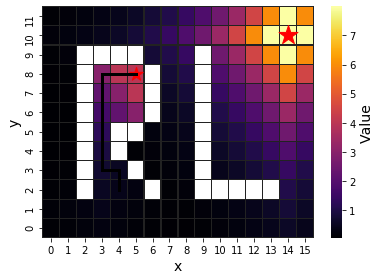

In [10]:
gridworld.display_best_path(values, gamma, (4,2), cmap=cm.get_cmap('inferno'), figsize=(5.5,4))